In [62]:
import pandas as pd
import numpy as np

In [63]:
df = pd.read_csv('Cleaned_data.csv')

In [64]:
df.head()

,country,year,cereal_yield,fdi_perc_gdp,en_per_gdp,en_per_cap,co2_ttl,co2_per_cap,co2_per_gdp,pop_urb_aggl_perc,prot_area_perc,gdp,gni_per_cap,under_5_mort_rate,pop_growth_perc,pop,urb_pop_growth_perc,urb_pop
0,AGO,1991,417.4,5.449515,179.271884,565.451027,4367.397,0.409949,129.971142,15.290728,12.399822,1.219375e+10,820.0,239.1,3.034866,10653515.0,6.687032,4099472.572
1,AGO,1992,397.0,4.982460,193.632183,550.548264,4418.735,0.401597,141.244823,15.660630,12.399823,5.779394e+09,470.0,235.3,3.226990,11002910.0,6.750459,4385759.926
2,AGO,1993,267.8,5.715529,266.318379,551.688878,5801.194,0.510141,246.261769,16.025739,12.399823,5.285600e+09,310.0,231.1,3.297243,11371750.0,6.700777,4689709.700
3,AGO,1994,298.4,4.195018,260.830190,541.553067,3890.687,0.331321,159.575256,16.065941,12.399824,4.059577e+09,190.0,226.3,3.212170,11742960.0,6.503667,5004849.552
4,AGO,1995,402.2,9.374417,237.623934,528.386164,11012.001,0.909699,409.106543,16.134424,12.399825,5.039535e+09,320.0,221.5,3.037335,12105105.0,6.223936,5326246.200


Using RandomForest

In [65]:
from sklearn.model_selection import train_test_split

In [360]:
X = df[["year", "gdp", "en_per_cap", "pop", "urb_pop"]] #features

In [361]:
y = df['co2_ttl']

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [363]:
X.shape

(1700, 5)

In [364]:
y.shape

(1700,)

In [365]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [366]:
import matplotlib.pyplot as plt

In [367]:
y_train_binned = pd.qcut(y_train, q=3, labels=["Low", "Medium", "High"])

making rf model

In [368]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=45,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

rf.fit(X_train, y_train_binned)

RandomForestClassifier(max_depth=45, min_samples_leaf=8, n_estimators=200,
                       random_state=42)

In [369]:
from sklearn.model_selection import cross_val_score

In [370]:
y_binned = pd.qcut(y, q=3, labels=["Low", "Medium", "High"])

checking cross validation; actual answer

In [371]:
scores = cross_val_score(rf, X, y_binned, cv=5, scoring='accuracy')
print("Cross-validation accuracy:", scores.mean())

Cross-validation accuracy: 0.8711764705882352


as the classes are imbalanced

In [372]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [373]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y_binned, cv=skf, scoring='accuracy')
print("Stratified CV Accuracy:", scores.mean())

Stratified CV Accuracy: 0.9558823529411764


plotting learning curve

In [374]:
from sklearn.model_selection import learning_curve

In [375]:
train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y_binned, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

In [376]:
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)#average score

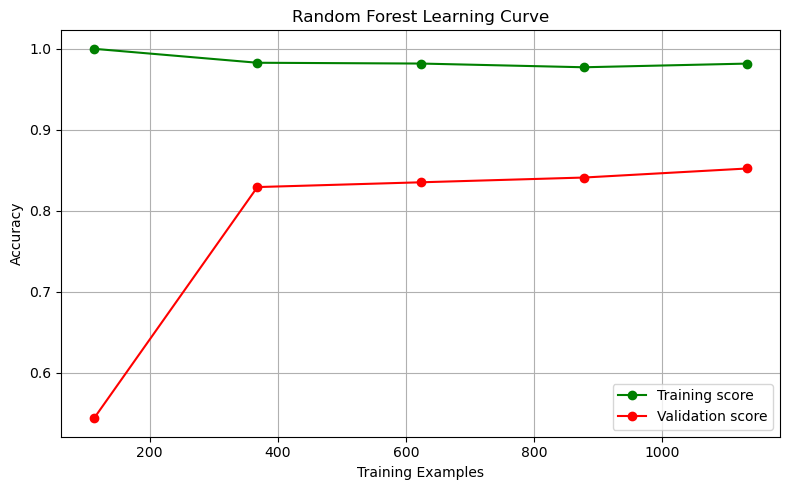

In [377]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score', color='green')
plt.plot(train_sizes, val_mean, 'o-', label='Validation score', color='red')
plt.title('Random Forest Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

analyzing feature importance

In [378]:
rf.fit(X_train, y_train_binned)

RandomForestClassifier(max_depth=45, min_samples_leaf=8, n_estimators=200,
                       random_state=42)

In [379]:
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [380]:
import seaborn as sns

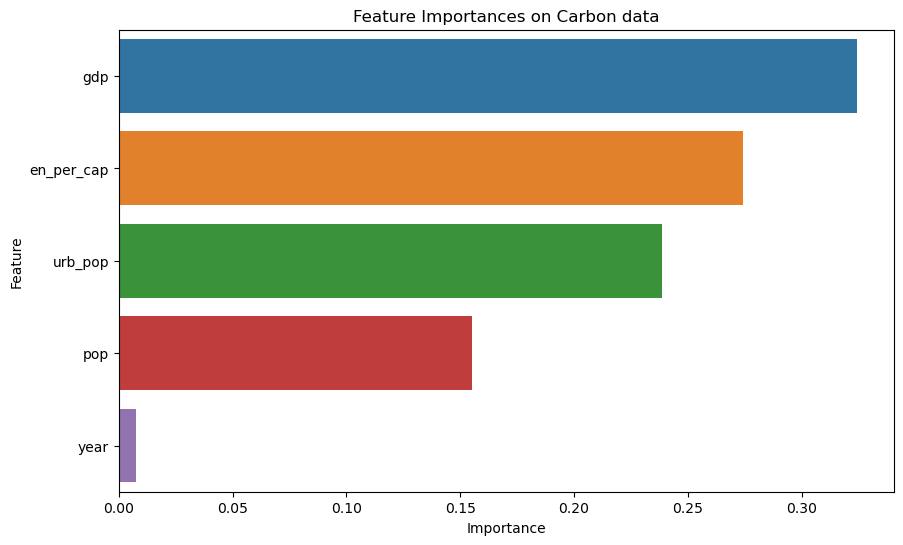

In [381]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importances on Carbon data")
plt.show()

prediction

In [382]:
y_pred = rf.predict(X_test)

In [383]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [384]:
y_test_binned = pd.qcut(y_test, q=3, labels=["Low", "Medium", "High"])

In [385]:
print("Accuracy:", accuracy_score(y_test_binned, y_pred))

Accuracy: 0.9382352941176471


classifiation & confusion metrics

In [386]:
print("\nClassification Report:\n", classification_report(y_test_binned, y_pred))


Classification Report:
               precision    recall  f1-score   support

        High       0.96      0.95      0.96       113
         Low       0.91      1.00      0.95       114
      Medium       0.94      0.87      0.90       113

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340



In [387]:
from sklearn.metrics import confusion_matrix

In [388]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test_binned, y_pred))


Confusion Matrix:
 [[107   0   6]
 [  0 114   0]
 [  4  11  98]]


In [389]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

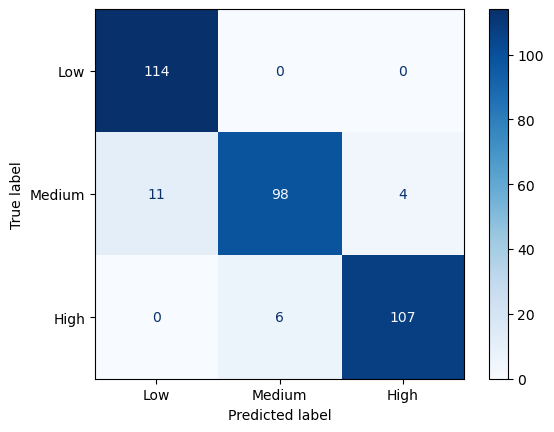

In [390]:
cm = confusion_matrix(y_test_binned, y_pred, labels=["Low", "Medium", "High"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap='Blues')

importing file as pickle

In [391]:
import joblib

In [392]:
rf

RandomForestClassifier(max_depth=45, min_samples_leaf=8, n_estimators=200,
                       random_state=42)

In [393]:
joblib.dump(rf, 'rf_co2_emission_prediction_model.pkl')

['rf_co2_emission_prediction_model.pkl']

In [356]:
print(y_train_binned.value_counts())

Low       454
Medium    453
High      453
Name: co2_ttl, dtype: int64


In [358]:
y_train_binned = pd.Categorical(y_train_binned, categories=["Low", "Medium", "High"], ordered=True)
y_train_binned

['Medium', 'Medium', 'Low', 'Low', 'Medium', ..., 'Low', 'High', 'Low', 'Low', 'Medium']
Length: 1360
Categories (3, object): ['Low' < 'Medium' < 'High']

In [359]:
rf.fit(X_train, y_train_binned)
joblib.dump(rf, 'rf_model.pkl')  

['rf_model.pkl']